In [1]:
# import numpy as np
from scipy.integrate import solve_ivp
# import ipywidgets
# from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
plt.style.use(['science', 'grid'])
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


# Case 1

In the script `data_gen.py`, I wrote a routine for generating steady states values. This script simulate different stages of a phenotypes using different `k6` parameters. In other words, it solves the same system of ODE with different `k6`. This is done by passing different `k6` as a parameter of the `ode` function.

The purpose of case 1 is, as stated in section 4.1.1 of the paper:

> to analyze whether changes in the transcriptional feedback could be identified at different stages of the intervention.

Here the change of k6 is required to be identified.

## Model

![true_system](rsfs20120084-g3.jpg)

The system is represented by the following equations:

$$
\begin{aligned}
\dot{x}_{1,...,4}(t, \theta)&=N f_{1,...,5}(x, \theta, u) \\
\dot{x}_5(t, \theta)&=f_6(x, \theta) \\
y(t,\theta)&=C x(t, \theta, u) \\
\end{aligned}
$$

Matrix $C$ filters out `R1` because only metabolite concentration could be measured (lab data). Generated data mimics the lab data and is fed into the model.

Matrix $N$ is the stoichiometry matrix of the system.
$$
N=\begin{pmatrix}
1 & 0 & -1 & -1 & 0 \\
-1 & 1 & 0 & 0 & 0 \\
1 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & -1 
\end{pmatrix}
$$

First, we need to define the model in case 1.
$$
\begin{aligned}
f_1(t, \theta)&=\frac{V_{max}}{K_i + R_1} u_1 S_2 \\
f_2(t,\theta)&=k_2 u_2 S_3 \\
f_3(t,\theta)&=k_3 S_1 \\
f_4(t,\theta)&=k_4 S_1 \\
f_5(t,\theta)&=k_5 S_4 \\
f_6(t,\theta)&=k_6 S_4 - k_d R_1
\end{aligned}
$$

In [2]:
# to make u1, u2 as functions
def u1(t):
    return 1

def u2(t):
    return 1

def fluxes(t, x, k6):

    S1 = x[0]
    S2 = x[1]
    S3 = x[2]
    S4 = x[3]
    R1 = x[4]

    # parameters
    Vmax = 1
    Ki = 0.1
    k2 = 1
    k3 = 0.1
    k4 = 0.5
    k5 = 1

    kd = 0.01


    f1 = (Vmax / (Ki + R1)) * u1(t) * S2
    f2 = k2 * u2(t) * S3
    f3 = k3 * S1
    f4 = k4 * S1
    f5 = k5 * S4
    f6 = k6 * S4 - kd * R1

    return [f1, f2, f3, f4, f5, f6]

Then, define the ode according to the the equation,
$$\dot{x} = N f$$
Here, $N$ is extended so that $\dot{x}_5=f_6$ is also taken into account.

In [3]:
def toyODE(t, x, k6):
    # k6_array = np.array([10, 4.2, 1.8, 0.7, 0.3]) * 1e-3
    # k6 = k6_array[i]
    N = array([
                [1,  0, -1, -1,  0, 0],
                [-1, 1,  0,  0,  0, 0],
                [1, -1,  0,  0,  0, 0],
                [0,  0,  0,  1, -1, 0],
                [0,  0,  0,  0,  0, 1]
        ])
    fx = fluxes(t, x, k6)
    dxdt = N.dot(fx)
    return dxdt

## Data set

Since case 1 is the reverse process of generating the data. It is important to understand how data is generated.

The data set is a matrix in figure (b), representing the 4 states at 5 time interval. The data matrix is sampled from distributions whose means are the steady states and the standard deviations are $20\%$ of the steady state at the first stage. As a result, we need to first *simulate the ODE system till steady state*.

First, the initial states are give as $x_0=[1.03, .38, .62, .52, .52]$. With the model defined as above, the ODE system is simulated from $t=0$ when $x=x_0$, using $k_6^1$. Then $x0$ is set to the end of the previous stage, and the $k_6^i$ is used to simulate stage $i$.

### Step 1: simulate each stage till steady states

The ODE system is simulated at 5 stages using 5 different `k6` till steady states (by simulating for long enough interval). Here, it is simulated for 1000 seconds.

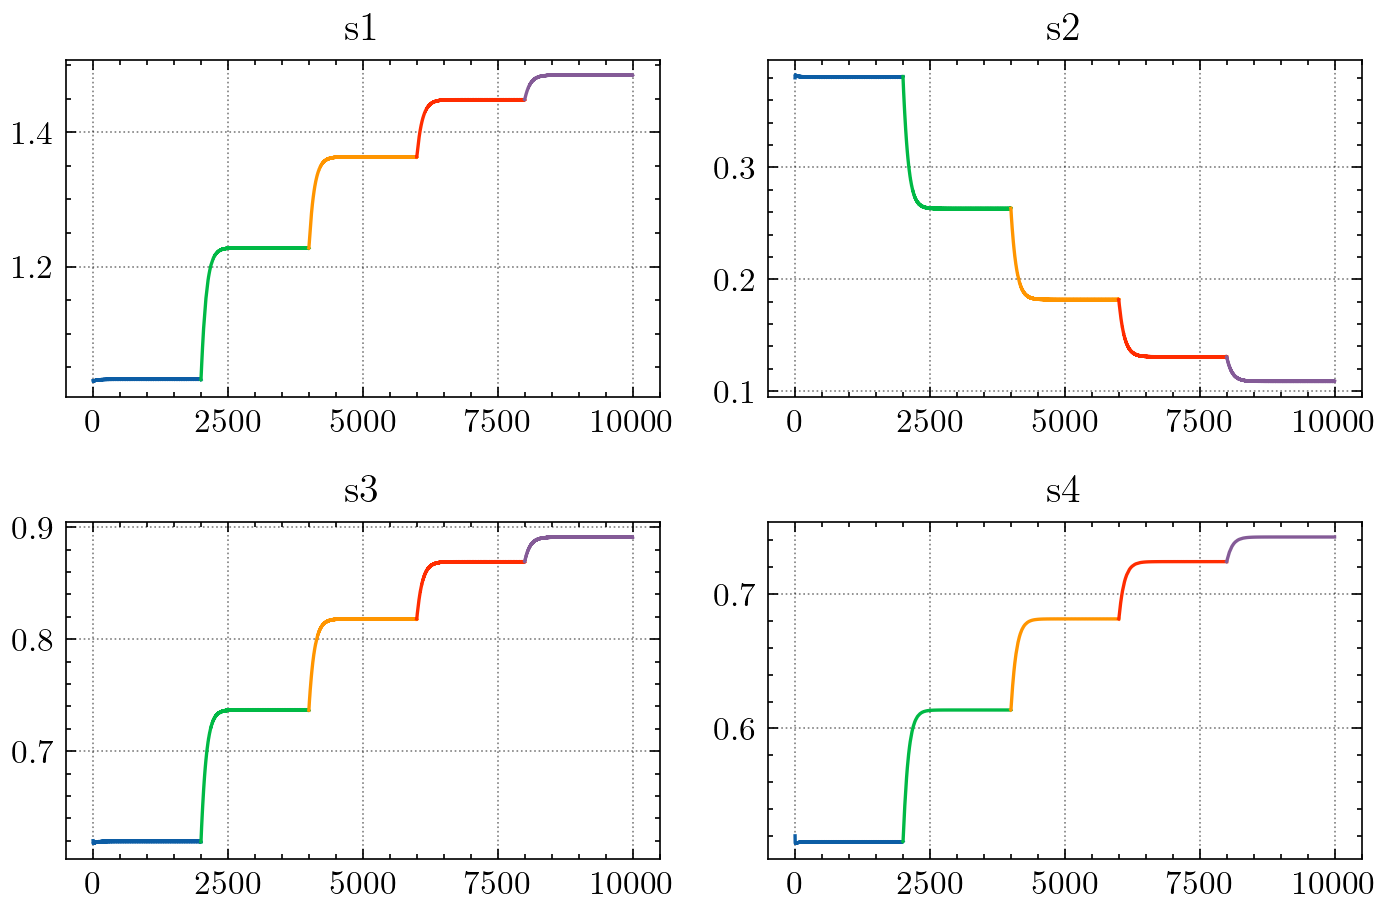

In [7]:
steady_states = list()
tstep_len =2000
k6_array = array([10, 4.2, 1.8, 0.7, 0.3]) * 1e-3
x_init = array([1.03, .38, .62, .52, .52])

fig, axes = subplots(2, 2, figsize=(6,4), dpi=120)
for i in arange(5):
#     print(x_init)
    t_span = [i*tstep_len, (i+1) * tstep_len]
    sol = solve_ivp(lambda t, y: toyODE(t, y, k6_array[i]), t_span, x_init)
    # print(sol.y.shape)
    for j in range(4):
        ax = axes[j//2, j%2]
        if not ax.title.get_label():
            ax.set_title('s' + str(j+1))
        ax.plot(sol.t, sol.y[j, :])
    x_init = sol.y[:, -1]
    steady_states.append(x_init)
fig.tight_layout()
steady_states = array(steady_states)

The steady states are the last values of a simulation procedure.
`steady_states` contains the steady states of the 5 variables in the 5 stages, thus, it is a 5 by 5 matrix. 
Since `R1` is not considered because the paper assumed that only metabolite concentrations could be measured,
only the first 4 columns of `steady_states` are valid.

array([[1.03154393, 0.38105148, 0.61894852, 0.51574427, 0.51575486],
       [1.22753776, 0.26345612, 0.73654388, 0.61374234, 0.25777473],
       [1.36320077, 0.18204222, 0.81795778, 0.68155374, 0.12268121],
       [1.44846698, 0.13088955, 0.86911045, 0.72419566, 0.05069404],
       [1.48514052, 0.10888723, 0.89111277, 0.7425347 , 0.02227616]])

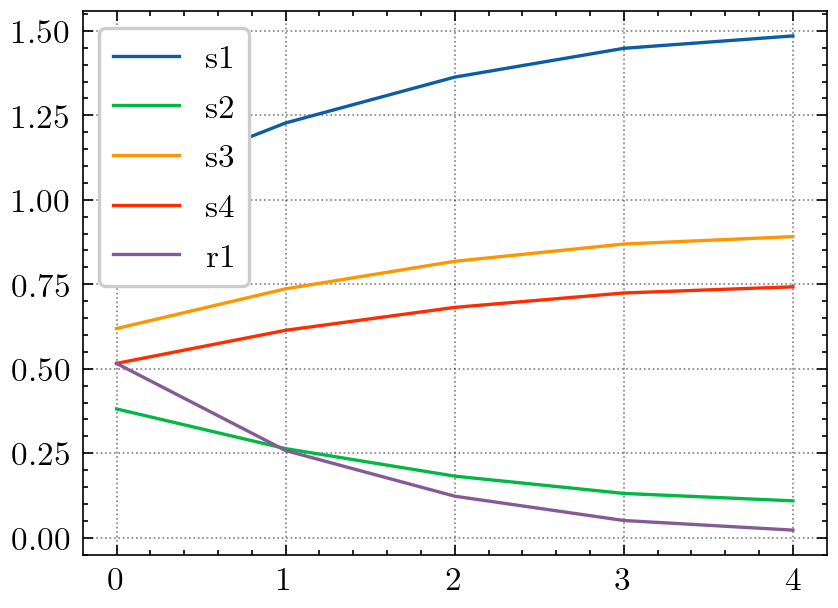

In [10]:
fig = subplots(figsize=(4,3), dpi=120)
plot(steady_states)
legend(['s1', 's2', 's3', 's4','r1'])
steady_states

### Step 2: create a data set generator

According to the InterfaceFocus 2013 paper by Natal van Riel, the standard deviation is chosen between $0$ and $20\%$ of the first stage (reference stage). 


$$ d^i=y^i_{ss}+\xi^i, i=1,...,5$$

In our code, $y^i_{ss}$ is the value at the last moment of every stage.

In [11]:
seed(0)
means = steady_states[:, :4]
stds = .2 * rand(*means.shape) * tile(means[0,:], (5,1))

Now we have the `means` and `stds` aligned. We can use them to generate the "mock" experimental data.

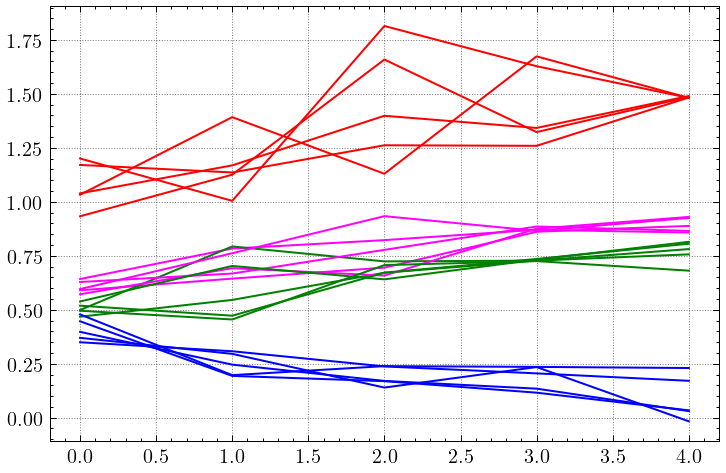

In [12]:
for i in range(5):
    noised = normal(means, stds)
    colors = ['red', 'blue', 'magenta', 'green']
    for i in range(noised.shape[1]):
        plot(noised[:,i], colors[i])

## Prediction

We need to feed this data back into the model to predict the value of `k6` in four stages. The optimizer is a [least squares](https://en.wikipedia.org/wiki/Least_squares) minimizer [`scipy.optimize.least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy-optimize-least-squares). The model is defined in function `toyODE`, whose argument `k6` is unknown in stage from 2 to 4.

>The value for `k6` in the reference condition is known and used as the initial value (guess) to start the numerical optimization algorithm to estimate the other datasets. The only uncertainty that needed to be considererd was due to the noise in the experimental data.

Least square is a very common optimization method. In scipy the default algorithm to implement least squares is Levenberg-Marquardt algorithm. The first step of least squares optimization (actually any optimization problem) is to define the objective function. The objective function is minimized by the optimizer. Here, the objective function is the SSE (Sum of squares errors).

`least_squares` has two positional arguments `func` and `x0`. Callable `func` is the objective function and scalar `x0` is the initial guesses on *independent variables*. The objective function `func` has a standard function profile (calling signature).  It must take a scalar `x` as the first argument. Note that `x` and `x0` must have the same length. In our case, the independent variable is the parameter `k6`.

In [13]:
from scipy.optimize import least_squares

### Define the objective function

The objective function (loss function, $\rho$ function) is composed of two parts, the sum of squares errors and regularization terms. In case 1, regularization is not taken into account, as $\lambda_r=0$.

We only need to consider the $SSE$ part

$$ k_6=argmin_{k_6^i} (X_d(\theta(t))$$

The objective function is a classica routine in bioinformatics. Given a initial guess $k_6^0$ and the expected output $d^i$:
1. solve the ODE using the initial guess, we have the model output $y^i$
2. return $d^i - y^i$ as an array

In [16]:
def objective_function(k6, tspan, x_init, di):
    # k6: the unknown parameter
    # tspan: time span 0 -> 1000
    # x_init: initial status of the system BEFORE the simulation
    # di: expected status AFTER the simulation
    sol = solve_ivp(lambda t, y: toyODE(t, y, k6),  tspan, x_init, method="LSODA")
    yi = sol.y[:4, -1]
    return yi - di

### Apply least squares method to the objective function

R1 is not considered because it doesn't exist in the data set. 

As can be observed from the figure of steady state simulation, the original `x_init` is a bit different from the actual steady states. We will use the value in `steady_states` as the new `x_init`.

The return value of `least_squares` is a `OptimizeResult` object `opt_res`.
`opt_res.x` is the solution (`k6` that minimizes the objective function).
The `k6` of the previous time step is used as the initial guess of the `k6` in following time step.

In [17]:
x_init = steady_states[0]
k6_pred = list()
k6_pred.append(k6_array[0])

data = normal(means, stds)

for s in range(1,5):
    # stage 2, 3, 4, 5
    k6 = k6_pred[s-1]
    tspan = [s*tstep_len, (s+1)*tstep_len]
    d_i = data[s] # the data at stage 1
    
    opt_res = least_squares(objective_function, k6, method='trf', args=(tspan, x_init, d_i))
    
    k6 = opt_res.x[0]
    k6_pred.append(k6)
    sol = solve_ivp(lambda t, y: toyODE(t, y, k6), tspan, x_init)
    x_init = sol.y[:, -1]

k6_pred = array(k6_pred)

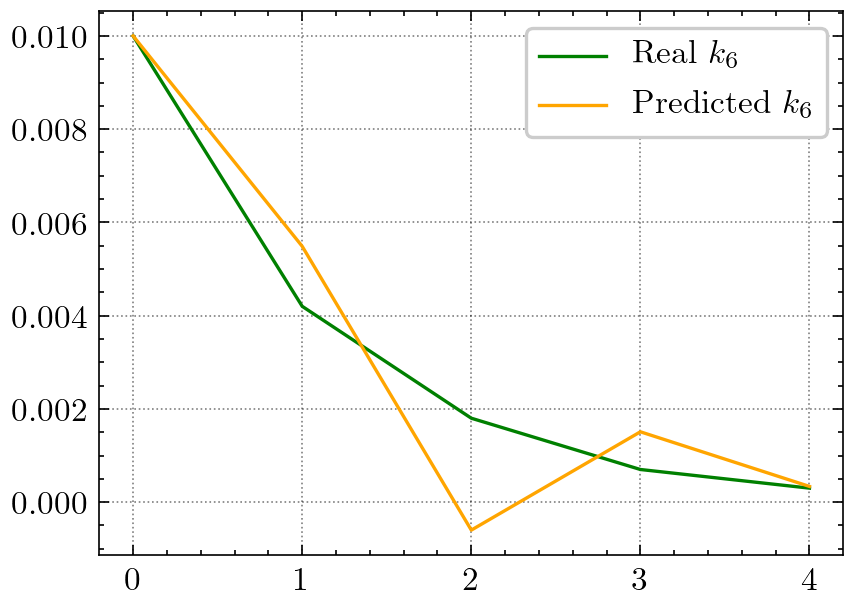

In [18]:
fig, axes = subplots(figsize=(4,3), dpi=120)
plot(k6_array, 'green')
plot(k6_pred, 'orange')
legend(['Real $k_6$', "Predicted $k_6$"]);

## Monte Carlo Approach

Although not demonstrated in the MATLAB code, the Interface Focus 2013 paper claimed to have performed Monte Carlo approach in case 2. Here we can also demonstrate to apply it in case 1. Generally speaking, Monte Carlo approach runs a random process many time to approximate a value of interest with the mean value of trials. We wrap the procedure above into function `trail`.

In [19]:
def trial(tr=0, method='lm'):
    x_init = steady_states[0]
    k6_pred = list()
    k6_pred.append(k6_array[0])

    data = normal(means, stds)
    
    k6 = k6_pred[0]
    for t in range(1, 5):
        # stage 2, 3, 4, 5        
        tspan = [t*tstep_len, (t+1)*tstep_len]
        d_i = data[t] # the data at stage 1
        opt_res = least_squares(objective_function, k6, method=method, args=(tspan, x_init, d_i))
        k6 = opt_res.x[0]
        k6_pred.append(k6)
        sol = solve_ivp(lambda t_, y: toyODE(t_, y, k6), tspan, x_init)
        x_init = sol.y[:, -1]

    return array(k6_pred)

Using `lm` as the least sqaures algorithm

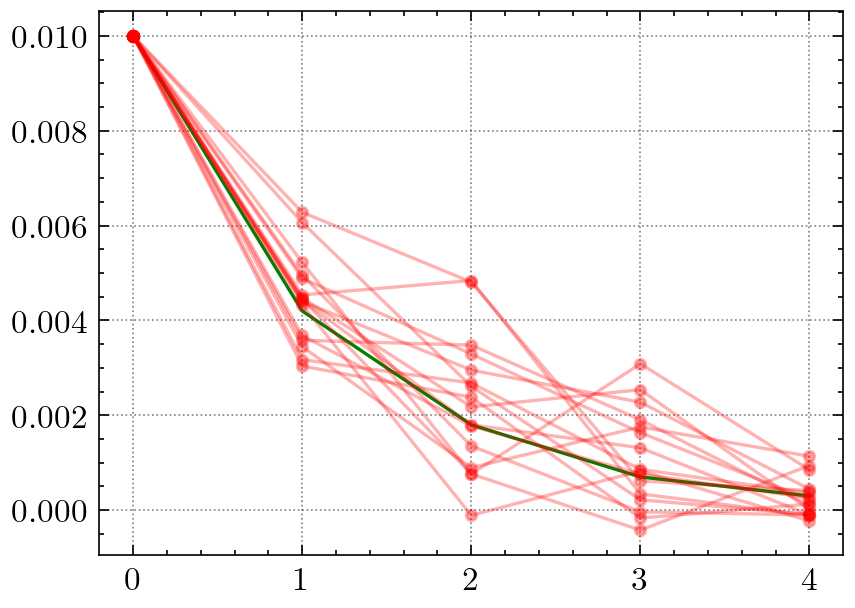

In [21]:
fig = figure(figsize=(4, 3), dpi=120)
plot(k6_array, 'green')
k6_mtx = list()

for tr in range(16):
    k6_pred = trial(tr)
#     print(i, k6_pred)
    plot(k6_pred, marker='.', color='red', alpha=0.3)
    k6_mtx.append(k6_pred)

k6_mtx = array(k6_mtx)

Use `trf` as the least squares algorithm

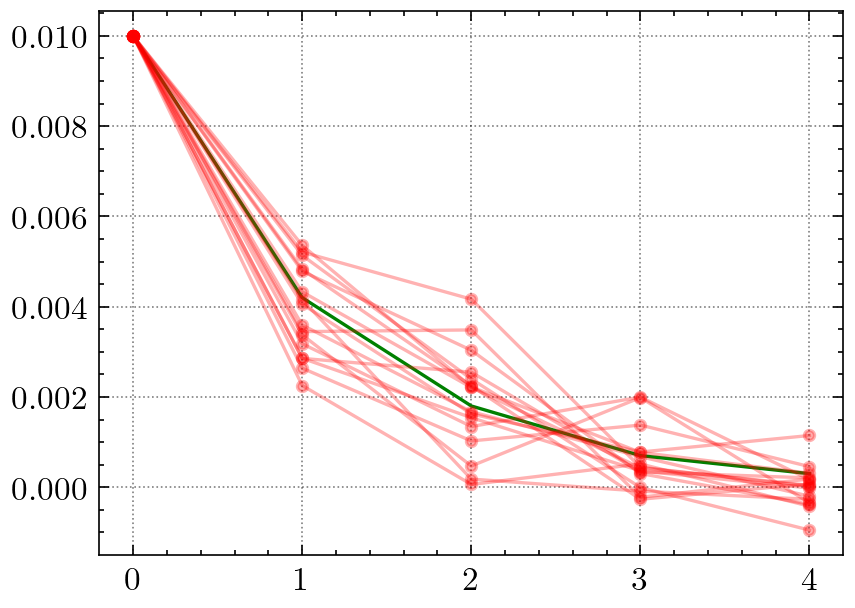

In [22]:
fig = figure(dpi=120, figsize=(4,3))
plot(k6_array, 'green')
k6_mtx = list()

for tr in range(16):
    k6_pred = trial(tr, method='trf')
#     print(i, k6_pred)
    plot(k6_pred, marker='.', color='red', alpha=0.3)
    k6_mtx.append(k6_pred)

k6_mtx = array(k6_mtx)

## Result

This is the result of 16 trials. One could image that as the number of trials increases, the result should further approximate the real data.

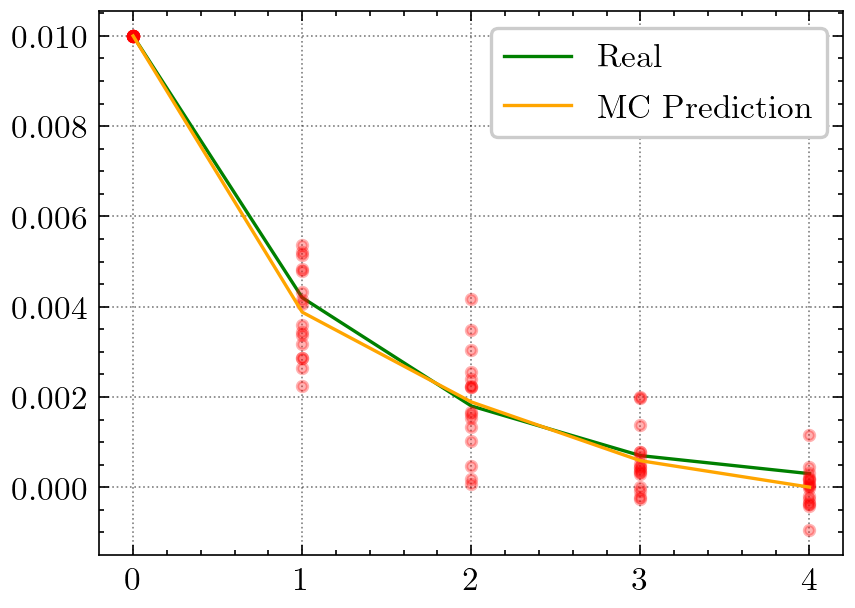

In [23]:
fig = figure(dpi=120, figsize=(4,3))
p1, = plot(k6_array, 'green')
for k6_pred in k6_mtx:
    plot(k6_pred, '.r', alpha=0.3)
p2, = plot(mean(k6_mtx, axis=0), 'orange')
legend([p1, p2], ['Real', 'MC Prediction'])